In [17]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from scipy.fft import fft, fftfreq
from scipy.optimize import minimize
import os
import uncertainties as u

In [18]:
#analysis functions
def getData(filename):
    # read in the data
    df = pd.read_csv(filename)
    # convert to numpy array
    data = df.to_numpy()
    time = data[:, 0]
    gyroZ = data[:, 1]
    in2 = data[:, 2]
    in1 = data[:, 3]
    # cutoff overalocated space where all values are 0
    cuttOffIdx = np.where(time == 0)
    time = time[:cuttOffIdx[0][0]]
    gyroZ = gyroZ[:cuttOffIdx[0][0]]
    in2 = in2[:cuttOffIdx[0][0]]
    in1 = (in1[:cuttOffIdx[0][0]])
    return time, gyroZ, in1, in2

def alignSignals(cutoffTime, time, in1, in2):
    in1Gain = 2.75
    if (cutoffTime == -1):
        staticTime = -1
    else:
        staticTime = np.where(time > cutoffTime)[0][0]
    S1 = in1[:staticTime]
    S2 = in2[:staticTime]
    avg = np.mean(S2)
    def calcGain(offset):
        return np.sum((S1*in1Gain + S2 + offset - 2*avg)**2) + np.sum((S1*in1Gain - S2 + offset)**2)
    # limit offset to 2
    res = minimize(calcGain, [0], bounds=[(-10, 10)])
    offset = res.x[0]
    in1Out = in1*in1Gain + offset
    in2Out = in2
    minValue = np.min([np.min(in1Out), np.min(in2Out)])
    in1Out = in1Out - minValue
    in2Out = in2Out - minValue
    return in1Out, in2Out

def filterSignals(time, in1, in2):
    # filter signals
    fs = 1/np.mean(time[1:]-time[:-1])
    b, a = signal.butter(5, 0.4, 'low', fs=fs)
    in1 = signal.filtfilt(b, a, in1)
    in2 = signal.filtfilt(b, a, in2)
    return in1, in2

def sumDiff(in1, in2):
    # sum and difference of signals
    Sum = in1+in2
    Diff = in1-in2
    return Sum, Diff

def calcOmega(Sum, Diff, A, Lambda):
    c = 2.99792458e8
    deltaPhi = np.arcsin(Diff/Sum)
    omega = deltaPhi/(8*A*np.pi)*Lambda*c
    #if any value is nan, set to 0
    omega[np.isnan(omega)] = 0
    return omega

def optimizeTotalPower(gyro, Sum, Diff, A, Lambda):
    # optimize total power so omega's line up, must be in a region where Sum is constant
    def calcErrorOmega(powerOffset):
        omega = calcOmega(Sum+powerOffset, Diff, A, Lambda)
        return np.sum((gyro - omega)**2)
    res = minimize(calcErrorOmega, [0], bounds=[(-10, 10)])
    powerOffset = res.x[0]
    return powerOffset
    
def calcPhi(Sum, Diff):
    deltaPhi = np.arcsin(Diff/Sum)
    return deltaPhi

def calcExpectedPhi(omega, A, Lambda):
    c = 2.99792458e8
    deltaPhi = omega*(8*A*np.pi)/Lambda/c
    return deltaPhi
    
def aSin(x):
    return np.arcsin(x)

asin = u.wrap(aSin)

def calcOmegaWithErr(Sum, Diff, A, Lambda, Verr, Aerr):
    c = 2.99792458e8
    Sum = u.ufloat(Sum, 2*Verr)
    Diff = u.ufloat(Diff, 2*Verr)
    A = u.ufloat(A, Aerr)
    deltaPhi = asin(Diff/Sum)
    omega = deltaPhi/(8*A*np.pi)*Lambda*c
    return omega
    #make u

In [19]:
#plotting functions
def plotSignals(time, gyroZ, in1, in2):
    #plot voltages and angular velocities on same plot with different y axes
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Signal Voltage (V)', color=color)
    ax1.plot(time, in1, 'bo', label='S1', markersize=1)
    ax1.plot(time, in2, 'ro',label='S2', markersize=1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('$\Omega$ (rad/s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, gyroZ, 'ko',label='Gyroscope', markersize=1)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='lower right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    return fig

def plotMathSignals(time, in1, in2, Sum, Diff):
    fig, ax = plt.subplots()
    ax.plot(time, in1, 'bo', label='S1', markersize=1)
    ax.plot(time, in2, 'ro',label='S2', markersize=1)
    ax.plot(time, Sum, 'go',label='S1+S2', markersize=1)
    ax.plot(time, Diff, 'ko',label='S1-S2', markersize=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal Voltage (V)')
    ax.legend(loc='upper right')
    return fig

def plotFFT(time, in1, in2):
    #plot fft of in1 and in2 on 2 separate plots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #in1
    # get the fft of the signals
    N = len(in1)
    T = np.mean(time[1:]-time[:-1])
    yf1 = fft(in1)
    yf2 = fft(in2)
    xf = fftfreq(N, T)[:N//2]
    ax1.plot(xf, 2.0/N * np.abs(yf1[0:N//2]), 'bo', label='S1', markersize=1)
    ax2.plot(xf, 2.0/N * np.abs(yf2[0:N//2]), 'ro', label='S1', markersize=1)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Amplitude')
    ax2.set_xlabel('Frequency (Hz)')
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax2.set_ylim([0,0.3])
    return fig

def plotOmega(time, gyro, rawOmega, filteredOmega):
    fig, ax = plt.subplots()
    ax.plot(time, rawOmega, 'bo', label='Unfiltered Laser Gyroscope', markersize=1)
    ax.plot(time, filteredOmega, 'ro', label='Filtered Laser Gyroscope', markersize=1)
    ax.plot(time, gyro, 'ko', label='Gyroscope', markersize=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$\Omega$ (rad/s)')
    ax.legend(loc='lower right')
    return fig

def plotPhi(time, deltaPhi, expectedDeltaPhi):
    fig, ax = plt.subplots()
    ax.plot(time, deltaPhi, 'bo', label='Measured $\Delta\phi$', markersize=1)
    ax.plot(time, expectedDeltaPhi, 'ro', label='Expected $\Delta\phi$', markersize=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$\Delta\phi$ (rad)')
    ax.legend(loc='lower right')
    return fig

def plotOmegaErr(time, gyro, omega, err):
    fig, ax = plt.subplots()
    ax.plot(time, gyro, 'bo', label='Gyroscope', markersize=1)
    ax.plot(time, omega, 'ro', label='Filtered Laser Gyroscope', markersize=1)
    ax.plot(time, omega-err, 'ko', markersize=1)
    ax.plot(time, omega+err, 'ko', markersize=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$\Omega$ (rad/s)')
    ax.legend(loc='lower right')
    return fig


In [20]:
def plotAllAndSave(fname, staticEnd, goodDataStart, goodDataEnd):
    #constants
    A = 0.634*0.438
    Lambda = 632.8e-9
    #strip the file extension and the folder name
    newFolderName = "plots/"+fname.split('/')[-1].split('.')[0]
    Fname = fname.split('/')[-1].split('.')[0]
    #make a new folder to save the plots if it doesn't already exist
    if not os.path.exists(newFolderName):
        os.mkdir(newFolderName)
    
    #gets the signals from the file
    time, gyroZ, in1, in2 = getData(fname)
    #getting the index of the signal where the data is good
    goodDataStart = np.where(time>goodDataStart)[0][0]
    if (goodDataEnd != -1):
        goodDataEnd = np.where(time>goodDataEnd)[0][0]

    #plotting the unprocessed signals
    fig = plotSignals(time, gyroZ, in1, in2)
    fig.savefig(newFolderName+'/' +Fname +'rawSignals.png', dpi=400, bbox_inches='tight')
    
    #gain and offset correction of the signals while setting the minumum value of the voltage to 0
    in1, in2 = alignSignals(staticEnd,time, in1, in2)
    fig = plotSignals(time, gyroZ, in1, in2)
    fig.savefig(newFolderName+ '/' + Fname + 'alignedSignals.png', dpi=400, bbox_inches='tight')
    
    #will plot the fft of the signals
    fig = plotFFT(time, in1, in2)
    fig.savefig(newFolderName + '/' + Fname +'fft.png', dpi=400, bbox_inches='tight')

    #low pass filter the signals to remove noise
    in1Filt, in2Filt = filterSignals(time, in1, in2)
    fig = plotSignals(time, gyroZ, in1Filt, in2Filt)
    fig.savefig(newFolderName+'/' + Fname + 'filteredAlignedSignals.png', dpi=400, bbox_inches='tight')

    #calc the sum and difference of the signals
    Sum, Diff = sumDiff(in1Filt, in2Filt)
    #use the measured gyroscope values to optimize the total signal power (may vary between trials because of small photodiode size)
    powerOffset = optimizeTotalPower(gyroZ[goodDataStart:goodDataEnd], Sum[goodDataStart:goodDataEnd], Diff[goodDataStart:goodDataEnd], A, Lambda)
    Sum = Sum + powerOffset
    in1Filt  = in1Filt + powerOffset/2
    in2Filt  = in2Filt + powerOffset/2
    fig = plotMathSignals(time, in1Filt, in2Filt, Sum, Diff)
    fig.savefig(newFolderName+'/' + Fname + 'manipulatedSignals.png', dpi=400, bbox_inches='tight')

    SumUnfilt, DiffUnfilt = sumDiff(in1, in2)
    SumUnfilt = SumUnfilt + powerOffset
    in1  = in1 + powerOffset/2
    in2  = in2 + powerOffset/2
    omega = calcOmega(Sum, Diff, A, Lambda)
    omegaUnfilt = calcOmega(SumUnfilt, DiffUnfilt, A, Lambda)
    fig = plotOmega(time, gyroZ, omegaUnfilt, omega)
    fig.savefig(newFolderName+'/' + Fname +'omega.png', dpi=400)

    deltaPhis = calcPhi(Sum, Diff)
    expectedDeltaPhis = calcExpectedPhi(gyroZ, A, Lambda)
    fig = plotPhi(time, deltaPhis, expectedDeltaPhis)
    #set image bounds for x larger to avoid cutting off the axis labels
    fig.savefig(newFolderName+'/' + Fname + 'phi.png', dpi=400, bbox_inches='tight')
    
    err = np.zeros(len(time))
    for i in range(omega.shape[0]):
        err[i] = (calcOmegaWithErr(Sum[i], Diff[i], A, Lambda, 0.07, 0.004)).std_dev
    fig = plotOmegaErr(time, gyroZ, omega, err)
    fig.savefig(newFolderName+'/' + Fname + 'omegaErr.png', dpi=400, bbox_inches='tight')
    #return gyro, omega, and err in good data range
    return gyroZ[goodDataStart:goodDataEnd], omega[goodDataStart:goodDataEnd], err[goodDataStart:goodDataEnd]

In [21]:
L = u.ufloat(0.634, 0.005)
W = u.ufloat(0.438, 0.005)
A = L*W
print(A)

0.278+/-0.004


In [22]:
folder = 'goodData/'
#numerical arguments, staticEnd, goodDataStart, goodDataEnd (seconds, -1 for end of array)
gyroz, omega, err = plotAllAndSave(folder+'finalStat.csv',-1,0,-1)
plt.close('all')
#add gyro omega and err into a master array
masterOmega = np.array([gyroz, omega, err])
time, gyroZ, in1, in2 = getData(folder+'finalStat.csv')
in1, in2 = alignSignals(-1,time, in1, in2)
#calc std dev of the signals
print("in1 std dev: ", np.std(in1))
print("in2 std dev: ", np.std(in2))
print("gyroZ std dev: ", np.std(gyroZ))
print("gryoZ mean: ", np.mean(gyroZ))

in1 std dev:  0.06965083905553214
in2 std dev:  0.06541210709013204
gyroZ std dev:  0.0014553148350114086
gryoZ mean:  -0.0208974110860909


In [23]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin1.csv',5,0,34)

plt.close('all')

In [24]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin2.csv',5,0,18)

plt.close('all')

In [25]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin3.csv',5,0,-1)
#add gyroz, omega, err to masterOmega
masterOmega = np.append(masterOmega, np.array([gyroz, omega, errr]), axis=1)
print(masterOmega.shape)
plt.close('all')

(3, 5784)


In [26]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin4.csv',5,0,-1)
masterOmega = np.append(masterOmega, np.array([gyroz, omega, errr]), axis=1)
print(masterOmega.shape)
plt.close('all')

(3, 10353)


In [27]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin5.csv',5,0,-1)
masterOmega = np.append(masterOmega, np.array([gyroz, omega, errr]), axis=1)
print(masterOmega.shape)
plt.close('all')

(3, 14547)


In [28]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin6.csv',5,0,-1)
plt.close('all')

In [29]:
gyroz, omega, errr = plotAllAndSave(folder+'finalSpin7.csv',3,50,55)
plt.close('all')

In [30]:
gyroz, omega, errr = plotAllAndSave(folder+"spinNeg1.csv", 5, 10, -1)
masterOmega = np.append(masterOmega, np.array([gyroz, omega, errr]), axis=1)
print(masterOmega.shape)
plt.close('all')

C:\Users\skell\AppData\Local\Temp\ipykernel_22772\1792133264.py:56: RuntimeWarning: invalid value encountered in arcsin
  deltaPhi = np.arcsin(Diff/Sum)


(3, 15764)


In [31]:
#save master omega to a csv file
df = pd.DataFrame(masterOmega)
df.to_csv('masterOmega.csv', header=False, index=False)


(3, 15764)


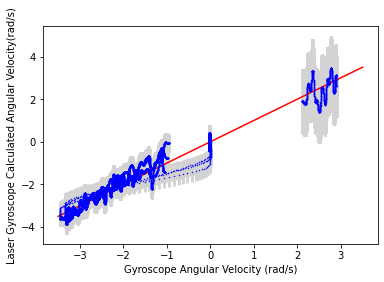

In [32]:
#open the master omega file
df = pd.read_csv('masterOmega.csv', header=None)
master = df.to_numpy()
print(master.shape)
Gyro = master[0,:]
Omega = master[1,:]
Err = master[2,:]
plt.errorbar(Gyro, Omega, yerr=Err, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, markersize=0.5)
#add a straight line for x = y between -3.5 and 3.5
plt.plot(np.linspace(-3.5,3.5,100), np.linspace(-3.5,3.5,100), color='red')
plt.xlabel('Gyroscope Angular Velocity (rad/s)')
plt.ylabel('Laser Gyroscope Calculated Angular Velocity(rad/s)')
plt.savefig('omegaVomega.png', dpi=400, bbox_inches='tight')
